# ABOUT THIS NOTEBOOK
## Purpose
This notebook attempts to refine various machine learning models used in implement_basic.ipynb.    
Results of the model fitting are analyzed.
## Input
'data_set.pickle' generated by 'data_processing.ipynb'.
## Output
Results of model fitting: plots, parameters and scores.
## Tasks Performed
* Load library packages
* Load pickle file
* Split data into train & test sets
* Implement functions for common tasks
* Run the following algorithms:
    * Random Forest Regressor
    * K Nearest Neighbors
    * Support Vector Machines
    * Linear Regression
    * Gradient Boosting Regressor
* For each of the algorithms perform the following:
    * Estimate feature importance / ranking
    * Learning curve, Validation curve plots
    * Hyperparameter selection

# LOAD LIBRARY PACKAGES

In [1]:
# Import the required library packages
import os
import re
import timeit

import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.learning_curve import learning_curve
from sklearn.learning_curve import validation_curve
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA

from six.moves import cPickle as pickle

# Settings for matplotlib, Seaborn
%matplotlib inline
sns.set_style('whitegrid')

# Set font sizes for matplots
plt.rcParams.update({'font.size': 15, 
                     'legend.fontsize': 'medium', 
                     'axes.titlesize': 'medium', 
                     'axes.labelsize': 'medium'})

print 'Read in packages from os, numpy, pandas, matplotlib, seaborn, sklearn & six'

Read in packages from os, numpy, pandas, matplotlib, seaborn, sklearn & six


# LOAD PICKLE FILE

In [2]:
pickle_file = 'data_set.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    pdata_set = save['data_set']
    del save
    print 'Loaded ptrain_set', pdata_set.shape
    
f.close()

Loaded ptrain_set (199584, 55)


In [3]:
pdata_set.columns.values

array(['district_id', 'num_day', 'time_slot', 'week_day', 'demand',
       'demand_t-1', 'demand_t-2', 'demand_t-3', 'supply', 'supply_t-1',
       'supply_t-2', 'supply_t-3', 'gap', 'weather', 'temperature',
       'pollution', 'poi_pc1', 'poi_pc2', 'poi_pc3', 'poi_pc4',
       'poi_cluster', 'tj_lvl1', 'tj_lvl2', 'tj_lvl3', 'tj_lvl4', 'dist_0',
       'dist_1', 'dist_2', 'dist_3', 'dist_4', 'dist_5', 'dist_6',
       'numday_0', 'numday_1', 'numday_2', 'numday_3', 'numday_4', 'ts_0',
       'ts_1', 'ts_2', 'ts_3', 'ts_4', 'ts_5', 'ts_6', 'ts_7', 'weekday_0',
       'weekday_1', 'weekday_2', 'poi_0', 'poi_1', 'poi_2', 'wthr_0',
       'wthr_1', 'wthr_2', 'wthr_3'], dtype=object)

# SPLIT DATA INTO TRAIN & TEST SETS

## Add square & cube root targets for gap

In [18]:
pdata_set['gap2'] = pdata_set['gap'] ** (1./2)
pdata_set['gap3'] = pdata_set['gap'] ** (1./3)

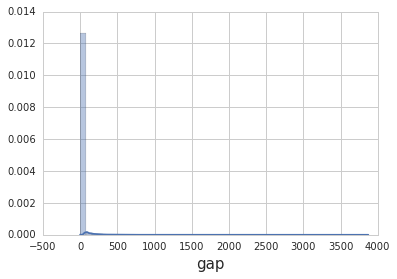

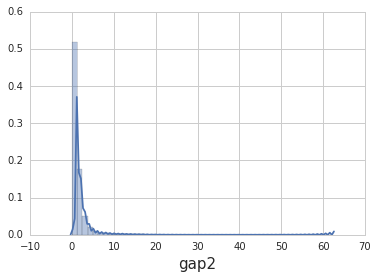

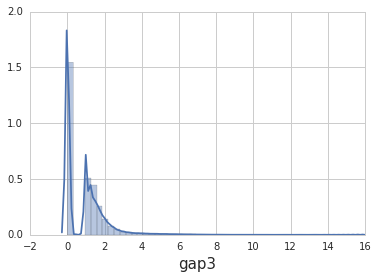

In [19]:
sns.distplot(pdata_set['gap'])
plt.show()
sns.distplot(pdata_set['gap2'])
plt.show()
sns.distplot(pdata_set['gap3'])

* Using the squareroot produces a slightly more discernible gaussian distribution and shortens the long tail.
* The cube root produces a multi-modal distribution with an even shorter tail.    
  We will rerun some algorithms using squareroot version of the gap.

## Add square root of input features

In [10]:
pdata_set['demand2'] = pdata_set['demand'] ** (1./2)
pdata_set['demand2_t-1'] = pdata_set['demand_t-1'] ** (1./2)
pdata_set['demand2_t-2'] = pdata_set['demand_t-2'] ** (1./2)
pdata_set['demand2_t-3'] = pdata_set['demand_t-3'] ** (1./2)

In [11]:
pdata_set['supply2'] = pdata_set['supply'] ** (1./2)
pdata_set['supply2_t-1'] = pdata_set['supply_t-1'] ** (1./2)
pdata_set['supply2_t-2'] = pdata_set['supply_t-2'] ** (1./2)
pdata_set['supply2_t-3'] = pdata_set['supply_t-3'] ** (1./2)

In [9]:
# Create new gap features for previous 3 time slots
pdata_set['gap2_t-1'] = (pdata_set['demand_t-1'] - pdata_set['supply_t-1']) ** (1./2)
pdata_set['gap2_t-2'] = (pdata_set['demand_t-2'] - pdata_set['supply_t-2']) ** (1./2)
pdata_set['gap2_t-3'] = (pdata_set['demand_t-3'] - pdata_set['supply_t-3']) ** (1./2)


## Use weeks 1 & 2 for training, week 3 for test

In [20]:
train_days     = range(1,15)
test_days      = range(15, 22)

X_train     = pdata_set[(pdata_set['num_day'].isin(train_days))]
X_test      = pdata_set[(pdata_set['num_day'].isin(test_days))]

print "Shape of X_train, X_test:", X_train.shape, X_test.shape, "\n\n"

Shape of X_train, X_test: (133056, 68) (66528, 68) 




## Generate scaled features for train & test sets

In [21]:
import warnings
warnings.filterwarnings('ignore')

gap_predictors = ['demand2_t-1', 'demand2_t-2', 'demand2_t-3',
                  'supply2_t-1', 'supply2_t-2', 'supply2_t-3',
                  'poi_pc1', 'poi_pc2',
                  'tj_lvl1', 'tj_lvl2', 'tj_lvl3',
                  'ts_0', 'ts_1', 'ts_2', 'ts_3', 'ts_4', 'ts_5', 'ts_6', 'ts_7',
                  'pollution', 'temperature',
                  'wthr_0', 'wthr_1', 'wthr_2', 'wthr_3',
                  'gap2_t-1', 'gap2_t-2', 'gap2_t-3'
                 ]  

gX_train = []
gy_train = []
gX_test  = []
gy_test  = []

# Use StandardScaler to achieve zero mean and unit variance
# Generate two scalers: input and target
input_scaler = StandardScaler().fit(pdata_set[gap_predictors])
target2_scaler = StandardScaler().fit(pdata_set['gap2'])

# Scale both training & test data
gX_train  = input_scaler.transform(X_train[gap_predictors])
gy2_train  = target2_scaler.transform(X_train['gap2'])

gX_test = input_scaler.transform(X_test[gap_predictors])
gy2_test = target2_scaler.transform(X_test['gap2'])

# IMPLEMENT FUNCTIONS FOR COMMON TASKS

## Scoring

In [22]:
# Generate Demand Supply Gap Metrics based on provided fit functions
# Assumes expected values for gap is in namesake column
def gap_estimate(**kwargs):
    """
    Generate scores for gap.
    
    Parameters
    ----------
    gX_train  : array containing train features
    gX_test   : array containing test features
    g_fitfunc : function to use for predicting
    """
    
    gX_train     = kwargs["gX_train"]
    gX_test      = kwargs["gX_test"]
    g_fitfunc    = kwargs["g_fitfunc"]
    
    print "\n\nGAP FORECASTING"
    print     "==============="

    # Generate predictions for train & test sets
    #gy_pred_train    = target_scaler.inverse_transform(g_fitfunc.predict(gX_train))
    #gy_pred_test     = target_scaler.inverse_transform(g_fitfunc.predict(gX_test))

    gy_pred_train    = target2_scaler.inverse_transform(g_fitfunc.predict(gX_train))
    gy_pred_test     = target2_scaler.inverse_transform(g_fitfunc.predict(gX_test))
   
    # Extract expected train & test values
    gy_train    = X_train['gap2']
    gy_test     = X_test['gap2']

    # Evaluate scores and print results
    print_score(gy_train**2, gy_pred_train**2, gy_test**2, gy_pred_test**2) 
    return

def print_score(y_train, y_pred_train, y_test, y_pred_test):
    
    """
    Present the MSE, R^2 and MAPE scores for train & test sets as a table.

    Parameters
    ----------
    y_train      : Array containing expected values for train set
    y_pred_train : Array containing predicted values for train set
    y_test       : Array containing expected values for test set
    y_pred_test  : Array containing predicted values for test set
    """
    
    m2score_train    = metrics.mean_squared_error(y_train,    y_pred_train)
    m2score_test     = metrics.mean_squared_error(y_test,     y_pred_test)


    r2score_train    = metrics.r2_score(y_train,    y_pred_train)
    r2score_test     = metrics.r2_score(y_test,     y_pred_test)

    # Assumes data is for 144 time slots, 14 days (train), 7 days (test)
    mpscore_train    = mape_score(y_train,    y_pred_train, ((144*14)-1))
    mpscore_test     = mape_score(y_test,     y_pred_test, ((144*7)-1))


    sets_list = ["TRAIN", "TEST"]

    m2_scores = [m2score_train, m2score_test]
    r2_scores = [r2score_train, r2score_test]
    mp_scores = [mpscore_train, mpscore_test]


    print '\t\tMEAN^2\t\tR2\t\tMAPE'

    for s, m, r, mp in zip(sets_list, m2_scores, r2_scores, mp_scores):
        print '{0:10}\t{1:.3f}\t\t{2:.3f}\t\t{3:.3f}' .format(s, m, r, mp)


def mape_score(exp, pred, q):
    
    """
    Generate the MAPE score value.

    Parameters
    ----------
    exp  : Array containing expected values
    pred : Array containing predicted values
    q    : Constant representing (number of days * number of time slots) - 1
    """
    
    mape = 0.0
    n = 66.0
    
    for gap, gapX in zip(exp, pred):
        if gap > 0:
            mape += 1.0 * abs((gap-gapX)/gap)
    return (mape/(n*q))

In [23]:
# Create a scorer function using the MAPE metric
# Use the training data size (144 time slots * 14 days) for q value

mape_scorer = make_scorer(mape_score, greater_is_better=False, q=((144*14)-1))

## Generate Learning & Validation Curves

In [24]:
def generate_learningcurves(sparse=False,**kwargs):
    ''' Generate learning curves by varying training sizes.
    Use Training vs Cross-validation curves.
    
    Arguments:
    gX_train -- Input features for training
    gy_train -- Target values for training
    alg -- Algorithm used for estimation
    alg_name -- Name of the algorithm
    
    Returns:
    Generates the learning curves plot.
    '''
   
    gX_train      = kwargs["gX_train"]
    gy_train      = kwargs["gy_train"]
    alg           = kwargs["alg"]
    alg_name      = kwargs["alg_name"]
    
    if (sparse):
        train_sizes = np.linspace(.01, 1.0, 6)
    else:
        train_sizes = np.linspace(.01, 1.0, 20)
    
    # Plot learning curve
    X, y = gX_train, gy_train
    title = 'Learning Curves for Gap (' + alg_name + ')'

    # Cross validation with 25 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=25, test_size=0.2, random_state=0)
    estimator = alg
    plot_learning_curve(estimator, alg_name, title, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
    plt.show()
    

        
def plot_learning_curve(estimator, alg_name, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curves.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
                An object of that type which is cloned for each validation.

    alg_name : name of the algorithm being tested
    
    title : string
            Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
           Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
         If an integer is passed, it is the number of folds (defaults to 3).
         Specific cross-validation objects can be passed, see
         sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
             Number of jobs to run in parallel (default 1).
             
    train_sizes : array, optional
                  Sizes of train set to use for generating the learning curve plot 
    """
    # Plot Learning Curve
    plt.figure(figsize=(15,8))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("R^2 Score")
    

    start = timeit.default_timer()
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, 
                                                            n_jobs=n_jobs, train_sizes=train_sizes)
    stop = timeit.default_timer()
    h, m, s = conv_seconds(stop - start)
    print 'Learning Curves Runtime: {0:d}h:{1:02d}m:{2:02d}s\n\n' .format(h, m, s) 
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    
    
    # Print Scores
    for train_size, train_score, test_score in zip(train_sizes, train_scores_mean, test_scores_mean):
        print ('Train Size: {0:7d} Train Score: {1:.3f} Test Score: {2:.3f}' .format(int(train_size), float(train_score), float(test_score)))
    
    return plt


def conv_seconds(seconds):
    '''
    Convert seconds to hours, minutes, seconds format.
    '''
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    return (int(h),int(m),int(s))


def plot_validation_curve(estimator, X, y, param_name, param_range, 
                          scoring, plot_title, x_label, y_label, n_jobs=-1):
    """
    Generate a simple plot of the validation curve for one hyperparameter.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
                An object of that type which is cloned for each validation.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    param_name : string with the name of the hyperparameter
    
    param_range : array with values for the hyperparameter
    
    scoring : scoring function to use
    
    plot_title : string
            Title for the chart.
            
    x_label: label for x-axis of the plot
    
    y_label: lable for y-axis of the plot
    
    n_jobs : integer, optional
             Number of jobs to run in parallel (default 1).
    """
    
    # Cross validation with 10 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=10, test_size=0.2, random_state=0)
    
    start = timeit.default_timer()
    train_scores, test_scores = validation_curve(estimator, X, y, param_name=param_name, param_range=param_range,
                                                 cv=cv, scoring=scoring, n_jobs=n_jobs)
    stop = timeit.default_timer()
    h, m, s = conv_seconds(stop - start)
    print 'Validation Curves Runtime: {0:d}h:{1:02d}m:{2:02d}s\n\n' .format(h, m, s)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Print Scores
    for param, train_score, test_score in zip(param_range, train_scores_mean, test_scores_mean):
        print ('{0}: {1:7d}    Train Score: {2:.3f} Test Score: {3:.3f}' .format(param_name, int(param), float(train_score), float(test_score)))
    
    plt.figure(figsize=(15,8))
    plt.title(plot_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="g")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.legend(loc="best")
    plt.show()

## Select Hyperparameters

In [25]:
def select_hyperparams(**kwargs):
    ''' Perform hyperparameter selection using grid search with 5x2 cross validation.
    Generate learning curves, scores for the best estimator.
    
    Arguments:
    gX_train -- Input features for training
    gy_train -- Target values for training
    gX_test -- Input features for test
    gy_test -- Target values for test
    alg -- Algorithm used for estimation
    alg_name -- Name of the algorithm
    param_grid -- Dictionary with hyperparameters and their range
    scoring_func -- Scoring function for the algorithm
    
    Returns:
    Best estimator found by performing grid search.
    Generates the learning curves, scores for best estimator.
    '''
        
    gX_train      = kwargs['gX_train']
    gy_train      = kwargs['gy_train']
    gX_test       = kwargs["gX_test"]
    gy_test       = kwargs["gy_test"]

    
    alg           = kwargs['alg']
    alg_name      = kwargs['alg_name']
    param_grid    = kwargs['param_grid']
    scoring_func  = kwargs['scoring_func']
    
    start = timeit.default_timer()
    # Use nested cross validation - 5x2 cross validation
    g_gs = GridSearchCV(estimator=alg,
                  param_grid=param_grid,
                  scoring=scoring_func,
                  cv=2,
                  n_jobs=-1)
   
    scores = cross_val_score(estimator=g_gs,
                         X=gX_train,
                         y=gy_train,
                         scoring=scoring_func,
                         cv=5)

    g_gs = g_gs.fit(X=gX_train, y=gy_train)
    
    stop = timeit.default_timer()
    h, m, s = conv_seconds(stop - start)
    print 'GridSearchCV Runtime: {0:d}h:{1:02d}m:{2:02d}s\n\n' .format(h, m, s)

    print 'All CV Scores:', scores
    print('Mean CV Score: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
    print 'Best Estimator:\n', g_gs.best_estimator_

   
    # Generate Learning Curves
    generate_learningcurves(sparse=True, gX_train=gX_train, gy_train=gy_train,
                            alg=g_gs.best_estimator_, alg_name=alg_name)
    
    # Print All Scores   
    gap_estimate(gX_train=gX_train, gX_test=gX_test, g_fitfunc=g_gs)

# RANDOM FORESTS

In [11]:
rf_predictors = [0,3,1,5,2,8,4,19]

## Hyper Parameter Selection
Use parameter values picked using validation curves. Add a additional values near the optimal value for grid selection. 

GridSearchCV Runtime: 0h:12m:47s


All CV Scores: [ 0.84490089  0.84212635  0.76769145  0.58470984  0.02463669]
Mean CV Score: 0.613 +/- 0.309
Best Estimator:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features=1.0, max_leaf_nodes=None, min_samples_leaf=5,
           min_samples_split=25, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)
Learning Curves Runtime: 0h:05m:23s


Train Size:    1064 Train Score: 0.553 Test Score: 0.338
Train Size:   22140 Train Score: 0.807 Test Score: 0.723
Train Size:   43216 Train Score: 0.837 Test Score: 0.771
Train Size:   64292 Train Score: 0.873 Test Score: 0.807
Train Size:   85368 Train Score: 0.899 Test Score: 0.836
Train Size:  106444 Train Score: 0.913 Test Score: 0.850


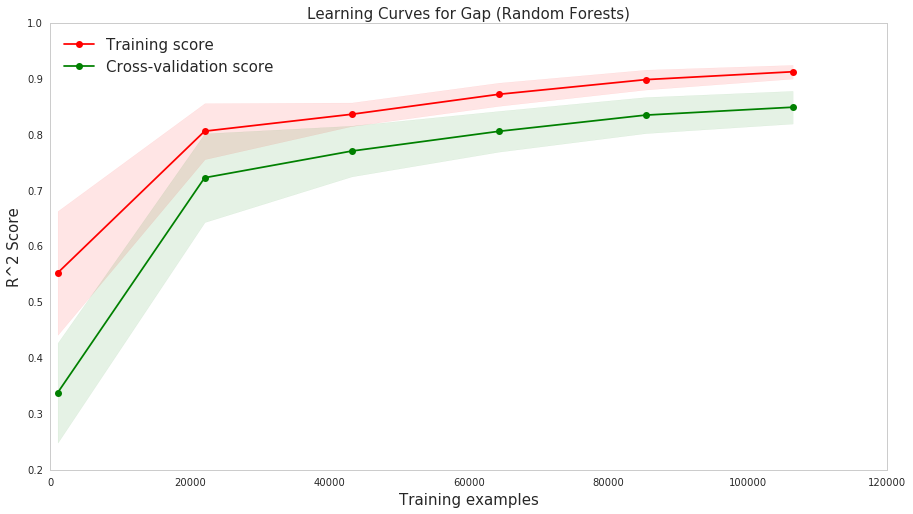



GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	151.085		0.921		0.367
TEST      	315.313		0.864		0.371


In [26]:
# Use GridSearchCV - RandomForestRegressor
# Specify parameters
param_grid = {'n_estimators'      : [300],
              'max_features'      : [1.0],
              'max_depth'         : [10, 11,12],
              'min_samples_split' : [15, 20, 25],
              'min_samples_leaf'  : [5, 6],
              'random_state'      : [0]}

alg = RandomForestRegressor()

# Only mse is supported for the RandomForestRegressor
# Use R^2 as scoring function for GridSearchCV, cross_val_score
select_hyperparams(gX_train=gX_train[:, rf_predictors], gy_train=gy_train, gX_test=gX_test[:, rf_predictors], gy_test=gy_test,
                   alg=alg, alg_name='Random Forests', param_grid=param_grid, scoring_func='r2')

# K NEAREST NEIGHBORS

In [32]:
knn_predictors = [0,3,1,5,2,8,4,19]

## Hyper Parameter Selection

GridSearchCV Runtime: 0h:00m:12s


All CV Scores: [ 0.79856636  0.77742912  0.72768037  0.55447625 -0.3710584 ]
Mean CV Score: 0.497 +/- 0.443
Best Estimator:
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='euclidean',
          metric_params=None, n_jobs=1, n_neighbors=7, p=2,
          weights='uniform')
Learning Curves Runtime: 0h:00m:22s


Train Size:    1064 Train Score: 0.574 Test Score: 0.364
Train Size:   22140 Train Score: 0.782 Test Score: 0.708
Train Size:   43216 Train Score: 0.817 Test Score: 0.755
Train Size:   64292 Train Score: 0.853 Test Score: 0.789
Train Size:   85368 Train Score: 0.870 Test Score: 0.802
Train Size:  106444 Train Score: 0.878 Test Score: 0.813


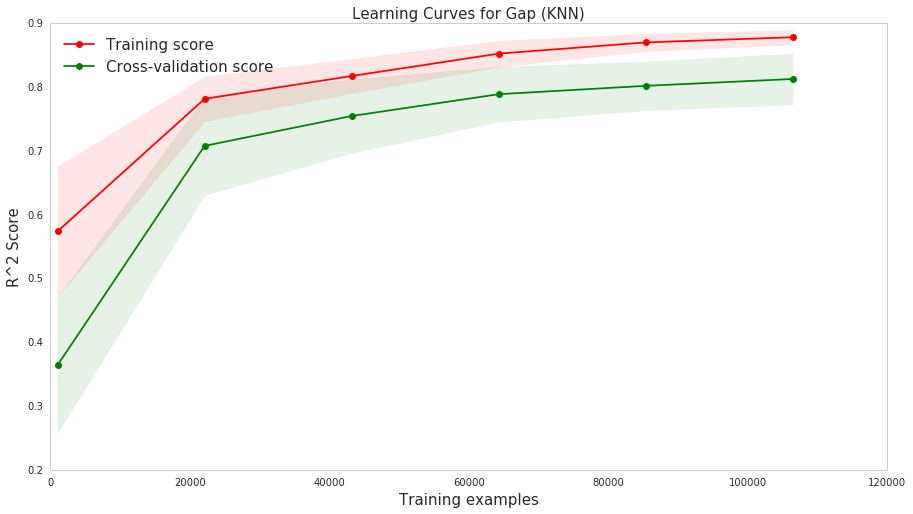



GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	220.446		0.885		0.347
TEST      	405.398		0.825		0.419


In [37]:
# Specify parameters
param_grid = {'n_neighbors' : [5, 6, 7],
              'weights'     : ['uniform'],
              'metric'      : ['euclidean', 'minkowski']}

alg = KNeighborsRegressor()

# Use R^2 as scoring function
select_hyperparams(gX_train=gX_train[:, knn_predictors], gy_train=gy_train, gX_test=gX_test[:, knn_predictors], gy_test=gy_test,
                   alg=alg, alg_name='KNN', param_grid=param_grid, scoring_func='r2')

# SUPPORT VECTOR MACHINES

In [31]:
svm_predictors = [0,3,1,4,2,5]

## Hyper Parameter Selection

GridSearchCV Runtime: 0h:15m:46s


All CV Scores: [ 0.86344628  0.84256625  0.8056179   0.90931007 -0.37709791]
Mean CV Score: 0.609 +/- 0.494
Best Estimator:
SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Learning Curves Runtime: 0h:06m:25s


Train Size:    1064 Train Score: 0.869 Test Score: 0.846
Train Size:   22140 Train Score: 0.888 Test Score: 0.869
Train Size:   43216 Train Score: 0.884 Test Score: 0.870
Train Size:   64292 Train Score: 0.889 Test Score: 0.870
Train Size:   85368 Train Score: 0.890 Test Score: 0.870
Train Size:  106444 Train Score: 0.890 Test Score: 0.870


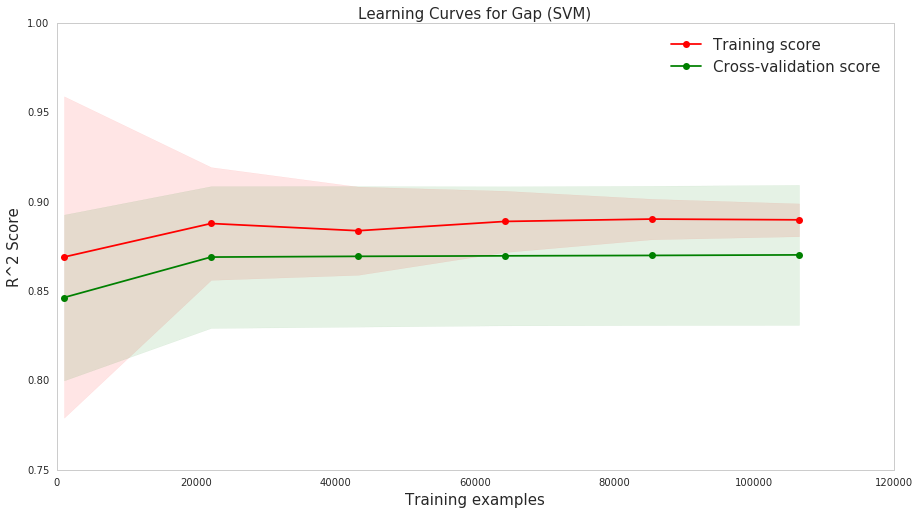



GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	212.829		0.888		0.419
TEST      	301.117		0.870		0.412


In [32]:
# Specify parameters
param_grid = {'kernel'      : ['linear'],
              'C'           : [1.0],
              'epsilon'     : [0.1],
              'cache_size'  : [1000]  # to improve runtime
             }

alg = SVR()

# Use R^2 as scoring function
select_hyperparams(gX_train=gX_train[:, svm_predictors], gy_train=gy_train, gX_test=gX_test[:, svm_predictors], gy_test=gy_test,
                   alg=alg, alg_name='SVM', param_grid=param_grid, scoring_func='r2')

# LINEAR REGRESSION

In [27]:
linear_predictors = [0,3,2,4]

## Hyper Parameter Selection

GridSearchCV Runtime: 0h:00m:04s


All CV Scores: [ 0.85669136  0.84451253  0.80138221  0.91703408 -0.55445102]
Mean CV Score: 0.573 +/- 0.565
Best Estimator:
LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=True)
Learning Curves Runtime: 0h:00m:08s


Train Size:    1064 Train Score: 0.880 Test Score: 0.854
Train Size:   22140 Train Score: 0.894 Test Score: 0.871
Train Size:   43216 Train Score: 0.890 Test Score: 0.873
Train Size:   64292 Train Score: 0.895 Test Score: 0.874
Train Size:   85368 Train Score: 0.896 Test Score: 0.874
Train Size:  106444 Train Score: 0.895 Test Score: 0.874


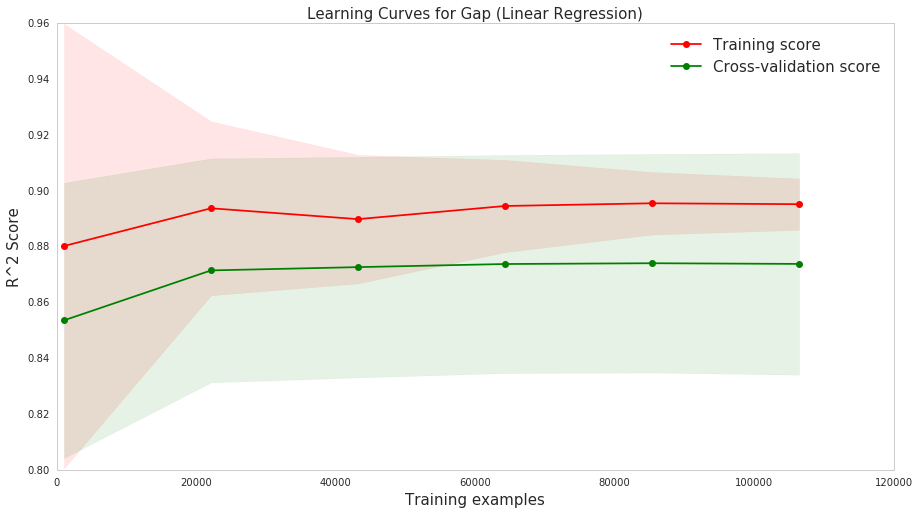



GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	203.251		0.894		0.569
TEST      	299.985		0.870		0.546


In [21]:
# No parameters to select
param_grid = {'fit_intercept'   : [True, False],
              'normalize'       : [True, False]
             }

alg = LinearRegression()

# Use R^2 as scoring function
select_hyperparams(gX_train=gX_train[:, linear_predictors], gy_train=gy_train, gX_test=gX_test[:, linear_predictors], gy_test=gy_test,
                   alg=alg, alg_name='Linear Regression', param_grid=param_grid, scoring_func='r2')

GridSearchCV Runtime: 0h:00m:04s


All CV Scores: [-0.19787649 -0.20052589 -0.16498206 -0.23818499 -0.079659  ]
Mean CV Score: -0.176 +/- 0.054
Best Estimator:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Learning Curves Runtime: 0h:00m:06s


Train Size:    1064 Train Score: 0.802 Test Score: 0.788
Train Size:   22140 Train Score: 0.795 Test Score: 0.793
Train Size:   43216 Train Score: 0.795 Test Score: 0.793
Train Size:   64292 Train Score: 0.795 Test Score: 0.793
Train Size:   85368 Train Score: 0.795 Test Score: 0.793
Train Size:  106444 Train Score: 0.795 Test Score: 0.793


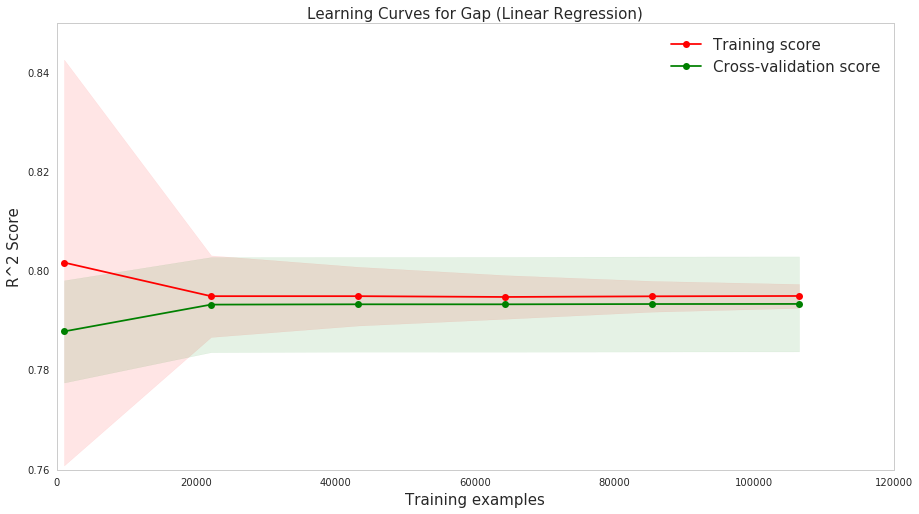



GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	384.439		0.799		0.412
TEST      	426.031		0.816		0.402


In [28]:
linear_predictors = [0,3,2,4]

# No parameters to select
param_grid = {'fit_intercept'   : [True, False],
              'normalize'       : [True, False]
             }

alg = LinearRegression()

# Use R^2 as scoring function
select_hyperparams(gX_train=gX_train[:, linear_predictors], gy_train=gy2_train, gX_test=gX_test[:, linear_predictors], gy_test=gy2_test,
                   alg=alg, alg_name='Linear Regression', param_grid=param_grid, scoring_func='mean_squared_error')

GridSearchCV Runtime: 0h:00m:03s


All CV Scores: [-0.1767626  -0.18332885 -0.15620242 -0.20290536 -0.06812893]
Mean CV Score: -0.157 +/- 0.047
Best Estimator:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Learning Curves Runtime: 0h:00m:08s


Train Size:    1064 Train Score: 0.825 Test Score: 0.810
Train Size:   22140 Train Score: 0.817 Test Score: 0.815
Train Size:   43216 Train Score: 0.817 Test Score: 0.815
Train Size:   64292 Train Score: 0.817 Test Score: 0.815
Train Size:   85368 Train Score: 0.817 Test Score: 0.815
Train Size:  106444 Train Score: 0.817 Test Score: 0.815


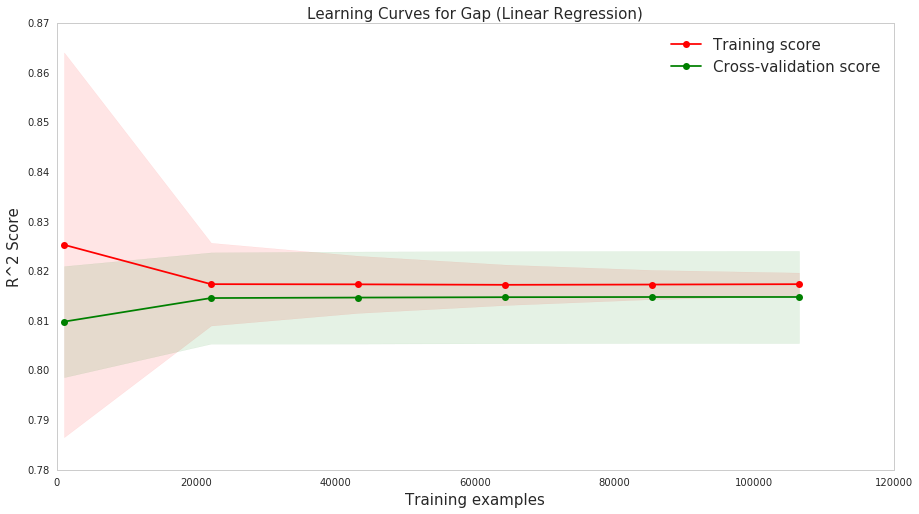



GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	261.045		0.863		0.399
TEST      	351.225		0.848		0.392


In [31]:
linear_predictors = [0,3,2,4,25,26,27]

# No parameters to select
param_grid = {'fit_intercept'   : [True, False],
              'normalize'       : [True, False]
             }

alg = LinearRegression()

# Use R^2 as scoring function
select_hyperparams(gX_train=gX_train[:, linear_predictors], gy_train=gy2_train, gX_test=gX_test[:, linear_predictors], gy_test=gy2_test,
                   alg=alg, alg_name='Linear Regression', param_grid=param_grid, scoring_func='mean_squared_error')

# GRADIENT BOOSTED TREES

## Hyper Parameter Selection

GridSearchCV Runtime: 0h:01m:03s


All CV Scores: [ 0.83548705  0.84789108  0.77977224  0.53527624 -0.22552939]
Mean CV Score: 0.555 +/- 0.406
Best Estimator:
GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.15, loss='ls',
             max_depth=5, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=3, min_samples_split=8,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=0.8, verbose=0,
             warm_start=False)
Learning Curves Runtime: 0h:01m:18s


Train Size:    1064 Train Score: 0.992 Test Score: 0.220
Train Size:   22140 Train Score: 0.971 Test Score: 0.779
Train Size:   43216 Train Score: 0.966 Test Score: 0.831
Train Size:   64292 Train Score: 0.967 Test Score: 0.852
Train Size:   85368 Train Score: 0.963 Test Score: 0.862
Train Size:  106444 Train Score: 0.962 Test Score: 0.875


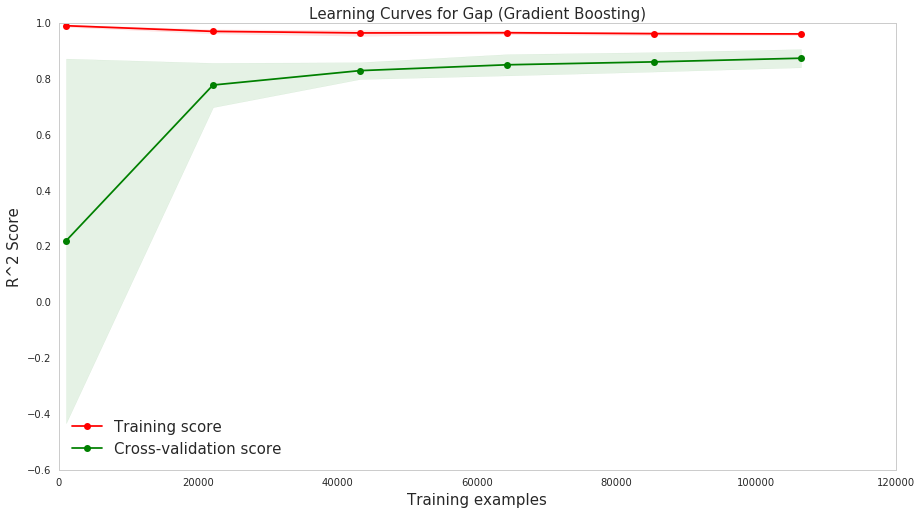



GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	76.891		0.960		0.414
TEST      	389.059		0.832		0.481


In [30]:
# No parameters to select
param_grid = {'learning_rate'          : [0.15],
              'n_estimators'           : [100],
              'max_depth'              : [5],
              'min_samples_split'      : [7,8],
              'min_samples_leaf'       : [3],
              'subsample'              : [0.8]
             }

alg = GradientBoostingRegressor()

# Use R^2 as scoring function
select_hyperparams(gX_train=gX_train[:, gbr_predictors], gy_train=gy_train, gX_test=gX_test[:, gbr_predictors], 
                   gy_test=gy_test, alg=alg, alg_name='Gradient Boosting', param_grid=param_grid, scoring_func='r2')

GridSearchCV Runtime: 0h:01m:10s


All CV Scores: [ 0.8166721   0.798981    0.76662952  0.77585313  0.00732133]
Mean CV Score: 0.633 +/- 0.313
Best Estimator:
GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.15, loss='ls',
             max_depth=5, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=3, min_samples_split=8,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=0.8, verbose=0,
             warm_start=False)
Learning Curves Runtime: 0h:02m:54s


Train Size:    1064 Train Score: 0.962 Test Score: 0.675
Train Size:   22140 Train Score: 0.887 Test Score: 0.818
Train Size:   43216 Train Score: 0.876 Test Score: 0.828
Train Size:   64292 Train Score: 0.870 Test Score: 0.831
Train Size:   85368 Train Score: 0.867 Test Score: 0.833
Train Size:  106444 Train Score: 0.864 Test Score: 0.834


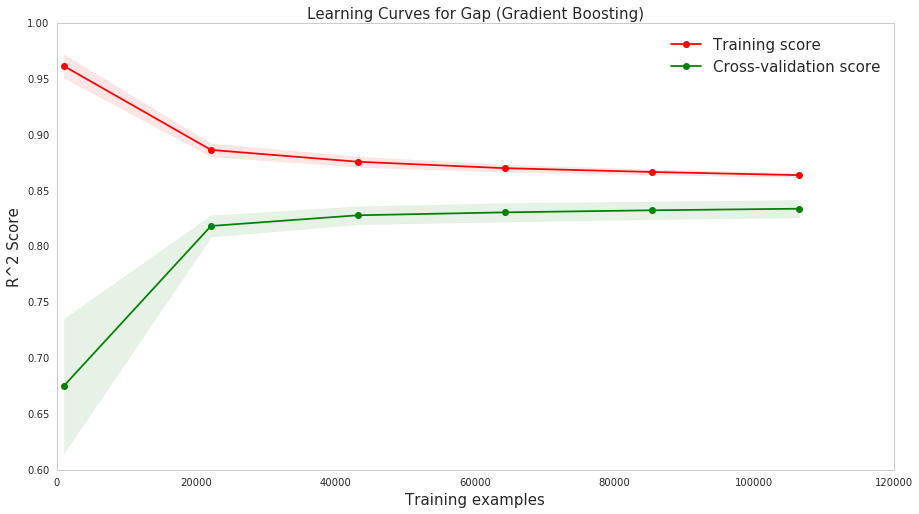



GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	80.385		0.958		0.354
TEST      	391.165		0.831		0.398


In [32]:
gbr_predictors = [0,3,2,1,20,9,5,19]

# No parameters to select
param_grid = {'learning_rate'          : [0.15],
              'n_estimators'           : [100],
              'max_depth'              : [5],
              'min_samples_split'      : [7,8],
              'min_samples_leaf'       : [3],
              'subsample'              : [0.8]
             }

alg = GradientBoostingRegressor()

# Use R^2 as scoring function
select_hyperparams(gX_train=gX_train[:, gbr_predictors], gy_train=gy2_train, gX_test=gX_test[:, gbr_predictors], 
                   gy_test=gy2_test, alg=alg, alg_name='Gradient Boosting', param_grid=param_grid, scoring_func='r2')

GridSearchCV Runtime: 0h:01m:31s


All CV Scores: [ 0.83807854  0.8278069   0.78057193  0.82207583  0.07668232]
Mean CV Score: 0.669 +/- 0.297
Best Estimator:
GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.15, loss='ls',
             max_depth=5, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=3, min_samples_split=7,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=0.8, verbose=0,
             warm_start=False)
Learning Curves Runtime: 0h:03m:53s


Train Size:    1064 Train Score: 0.971 Test Score: 0.752
Train Size:   22140 Train Score: 0.897 Test Score: 0.834
Train Size:   43216 Train Score: 0.888 Test Score: 0.841
Train Size:   64292 Train Score: 0.883 Test Score: 0.844
Train Size:   85368 Train Score: 0.879 Test Score: 0.846
Train Size:  106444 Train Score: 0.877 Test Score: 0.846


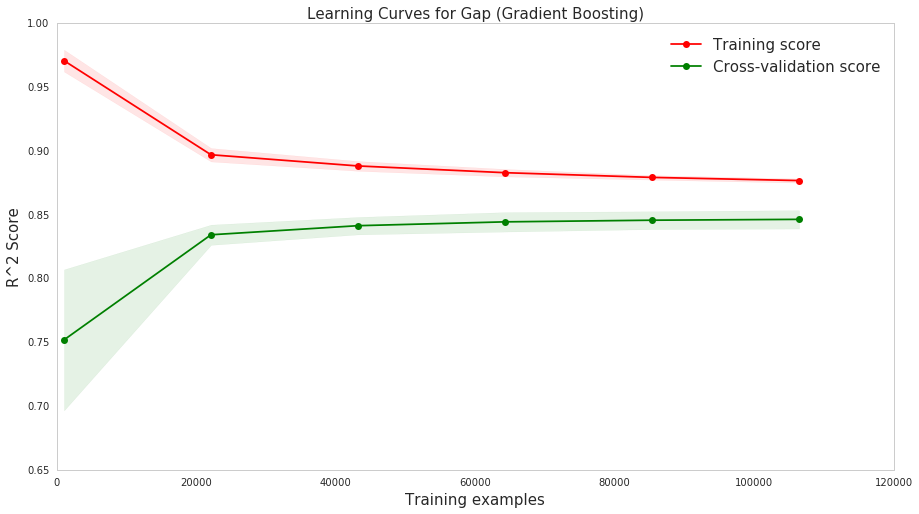



GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	62.939		0.967		0.354
TEST      	349.143		0.849		0.393


In [33]:
gbr_predictors = [0,3,2,1,20,9,5,19,25,26,27] 
# No parameters to select
param_grid = {'learning_rate'          : [0.15],
              'n_estimators'           : [100],
              'max_depth'              : [5],
              'min_samples_split'      : [7,8],
              'min_samples_leaf'       : [3],
              'subsample'              : [0.8]
             }

alg = GradientBoostingRegressor()

# Use R^2 as scoring function
select_hyperparams(gX_train=gX_train[:, gbr_predictors], gy_train=gy2_train, gX_test=gX_test[:, gbr_predictors], 
                   gy_test=gy2_test, alg=alg, alg_name='Gradient Boosting', param_grid=param_grid, scoring_func='r2')